In [1]:
import pandas as pd 
import numpy as np
from fastdtw import dtw, fastdtw
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
T = 5.0         # Sample Period
fs = 80       # sample rate, Hz
cutoff = 1      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [3]:
def scaler(arr, feat_range=(-1, 1)):
    a, b = feat_range
    min_val = min(arr)
    max_val = max(arr)

    return [a + ((x-min_val) * (b-a) / (max_val-min_val)) for x in arr]

In [4]:
# Function to get the maxima and minima points of the curve
def getMaxMinima(data):

    if data[1] >= data[0]:
        pos_momentum = True
    else: 
        pos_momentum = False

    maxima = list()
    minima = list()

    for i in range(len(data)):
        if i == 0:
            continue
        if pos_momentum:
            if data[i] - data[i-1] < 0:  # Maxima condition
                maxima.append(i-1)
                pos_momentum = False
        else:
            if data[i] - data[i-1] > 0:  # Minima condition
                minima.append(i-1)
                pos_momentum = True
    
    return (maxima, minima)
        

In [20]:
def l2dist(data1, data2):
    dist = 0
    for points in zip(data1, data2):
        a, b = points
        print(a)
        print(b)
        dist += np.linalg.norm(np.array(a) - np.array(b), 2)
    return dist

In [6]:
def horizontalDist(data1, data2):
    hdist = 0
    for a, b in zip(data1, data2):
        hdist += np.sqrt((a[0] - b[0]) ** 2)

    return hdist

In [13]:
#l2dist((3, 3), (2, 2))

np.linalg.norm(np.array((3,3)) - np.array((2, 2)), 2)

1.4142135623730951

In [14]:
def dtwAlgorithm(data1, data2, xdata, subject, filtering=True, plots=False):

    data1_filtered = data1
    data2_filtered = data2

    # Preprocess data points by passing them through Low Pass filter
    if filtering:
        data1_filtered = butter_lowpass_filter(data1, cutoff, fs, order)
        data2_filtered = butter_lowpass_filter(data2, cutoff, fs, order)

    # Min Max Scaling the filtered data points 
    data1_scaled = scaler(data1_filtered)
    data2_scaled = scaler(data2_filtered)

    # Get Maxima and Minima points
    maxima, minima = getMaxMinima(data2_scaled)
    data2_maxima = [data2_scaled[x] for x in maxima]
    data2_minima = [data2_scaled[x] for x in minima]

    if plots:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(xdata, data1_scaled, "r--", alpha=0.4, label="Ball curve (Sine wave)")
        ax.plot(xdata, data2_scaled, "b", label="Subject Data (Filtered)")
        ax.scatter(maxima, data2_maxima, s=150, c="red", marker="X")
        ax.scatter(minima, data2_minima, s=150, c="red", marker="X")
        ax2 = ax.twinx()
        ax2.plot(xdata, data2, "g--", alpha=0.4, label="Subject Data (Unfiltered)")
        ax.grid(False)
        ax2.grid(False)
        fig.legend()
        plt.xlabel("Frame")
        plt.ylabel("Y Values")
        fig.suptitle(subject + " Data")
        
    xdata_scaled = scaler(xdata)

    # DTW Processing
    data1_zipped = list(map(list, zip(xdata_scaled, data1_scaled)))
    data2_zipped = list(map(list, zip(xdata_scaled, data2_scaled)))
    distance, path = dtw(data1_zipped, data2_zipped, dist=2)
    # print(distance)

    # Euclidean distance calculation between the mapped points
    data1_index = [x[0] for x in path]
    data2_index = [x[1] for x in path]
    datax_zipped = list(map(list, zip(data1_index, data1_scaled)))
    datay_zipped = list(map(list, zip(data2_index, data2_scaled)))
    
    mdist = l2dist(datax_zipped, datay_zipped)

    hdist = horizontalDist(datax_zipped, datay_zipped)

    # Index map plots post time warping 
    if plots:
        data1_index = [x[0] for x in path]
        data2_index = [x[1] for x in path]

        plt.figure(figsize=(15, 15))
        plt.plot(data1_index, data2_index)
        plt.xlabel("Subject Data Index")
        plt.ylabel("Ball Curve Index")
        plt.suptitle(subject + " Time Warped Index")
    
    return (distance, path, mdist, hdist)

In [38]:
def dtwUnfiltered(data1, data2, xdata, subject, filtering=True, plots=False):

    data1_filtered = data1
    data2_filtered = data2

    # Preprocess data points by passing them through Low Pass filter
    if filtering:
        data1_filtered = butter_lowpass_filter(data1, cutoff, fs, order)
        # data2_filtered = butter_lowpass_filter(data2, cutoff, fs, order)

    # Min Max Scaling the filtered data points 
    data1_scaled = scaler(data1_filtered)
    data2_scaled = scaler(data2_filtered)

    # Get Maxima and Minima points
    # maxima, minima = getMaxMinima(data2_scaled)
    # data2_maxima = [data2_scaled[x] for x in maxima]
    # data2_minima = [data2_scaled[x] for x in minima]        
        
    xdata_scaled = scaler(xdata)

    # DTW Processing
    data1_zipped = list(map(list, zip(xdata_scaled, data1_scaled)))
    data2_zipped = list(map(list, zip(xdata_scaled, data2_scaled)))
    distance, path = dtw(data1_zipped, data2_zipped, dist=2)
    # print(distance)

    # Euclidean distance calculation between the mapped points
    data1_index = [x[0] for x in path]
    data2_index = [x[1] for x in path]
    datax_zipped = list(map(list, zip(data1_index, data1_scaled)))
    datay_zipped = list(map(list, zip(data2_index, data2_scaled)))
    
    mdist = l2dist(datax_zipped, datay_zipped)
    hdist = horizontalDist(datax_zipped, datay_zipped)
    
    return (distance, path, mdist, hdist)

In [15]:
col_names = ["Subject", "TimeStamp", "Frame", "RealVal", "Data"]
df = pd.read_csv("grabAngles.csv", names=col_names)
df.head()

,Subject,TimeStamp,Frame,RealVal,Data
0,PNUMBER,0.000000,0,3.000000,-0.284286
1,PNUMBER,0.011057,1,2.999424,-0.288871
2,PNUMBER,0.022263,2,2.997611,-0.294694
3,PNUMBER,0.033731,3,2.994474,-0.296490
4,PNUMBER,0.044705,4,2.990265,-0.297635


In [16]:
zero_ind = list(df[df["Frame"] == 0].index)
zero_ind.append(df.shape[0])

subs = ["Brendan1", "Brendan2", "Brendan3",
       "Sundar1", "Sundar2", "Sundar3", 
       "Naren1", "Naren2", "Naren3"]

for i in range(len(subs)):
    m = zero_ind[i] 
    n = zero_ind[i+1]
    df.loc[m:n, "Subject"] = subs[i]
    
df

,Subject,TimeStamp,Frame,RealVal,Data
0,Brendan1,0.000000,0,3.000000,-0.284286
1,Brendan1,0.011057,1,2.999424,-0.288871
2,Brendan1,0.022263,2,2.997611,-0.294694
3,Brendan1,0.033731,3,2.994474,-0.296490
4,Brendan1,0.044705,4,2.990265,-0.297635
...,...,...,...,...,...
8753,Naren3,11.616990,1046,2.358568,-0.707618
8754,Naren3,11.628040,1047,2.390755,-0.643424
8755,Naren3,11.639250,1048,2.422923,-0.569885
8756,Naren3,11.650270,1049,2.454037,-0.537540


In [21]:
temp = df[df["Subject"] == "Brendan1"]
len1 = temp.shape[0]
x = list(temp.loc[:len1 - 51, "RealVal"])
y = list(temp.loc[50:, "RealVal"])
lendata = list(range(len(x)))

dist, path, mdist, hdist = dtwAlgorithm(x, y, lendata, "Naren3", plots=False)

[0, 1.0]
[0, -0.243895667280142]
[1, 0.9920826570224297]
[0, -0.26815590731663674]
[2, 0.9835829387586976]
[0, -0.2928545567291718]
[3, 0.9744787062954816]
[0, -0.3179321155807283]
[4, 0.9647484191387328]
[0, -0.34332741819668655]
[5, 0.9543713647387702]
[0, -0.36897801907568395]
[6, 0.9433278666202605]
[0, -0.3948205512888643]
[7, 0.9315994721519314]
[0, -0.4207910524632187]
[8, 0.9191691196701384]
[0, -0.44682526573497316]
[9, 0.9060212853592546]
[0, -0.4728589237555292]
[10, 0.8921421104616518]
[0, -0.49882801447366343]
[11, 0.8775195091044969]
[0, -0.5246690221304384]
[12, 0.8621432580096544]
[0, -0.5503191439025943]
[13, 0.8460050700281108]
[0, -0.5757164880383716]
[14, 0.8290986528738948]
[0, -0.6008002560894832]
[15, 0.81141975474826]
[0, -0.6255109082014885]
[16, 0.7929661973494908]
[0, -0.6497903109578098]
[17, 0.7737378968505726]
[0, -0.6735818708963779]
[18, 0.7537368766125665]
[0, -0.6968306563857571]
[19, 0.7329672712715134]
[0, -0.7194835061220592]
[20, 0.7114353175901109

In [22]:
mdist

39234.77237590453

In [23]:
hdist

39221.0

In [33]:
sub_cols = ["Subject", "Distance", "Horizontal Distance"]
sub_df = pd.DataFrame(columns=sub_cols)

for sub in subs:
    temp = df[df["Subject"] == sub]
    dist, path, mdist, hdist = dtwAlgorithm(temp["RealVal"], temp["Data"], temp["Frame"], sub, plots=False)
    
    sub_df = sub_df.append(dict(zip(sub_cols, [sub, mdist, hdist])), ignore_index=True)

In [34]:
sub_df

,Subject,Distance,Horizontal Distance
0,Brendan1,10588.926775,10582.0
1,Brendan2,17495.758563,17489.0
2,Brendan3,9498.054404,9493.0
3,Sundar1,9562.848214,9552.0
4,Sundar2,6729.850872,6718.0
5,Sundar3,7074.660370,7069.0
6,Naren1,9550.299391,9539.0
7,Naren2,12570.584596,12561.0
8,Naren3,27367.114630,27358.0


,Subject,FS DTW Distance,FS Horizontal Distance,UFS DTW Distance,UFS Horizontal Distance,UFF DTW Distance,UFF Horizontal Distance
0,Sundar2,6729.850872,6718.0,10465.636345,10434.0,814.834194,811.0
1,Brendan2,17495.758563,17489.0,15830.809318,15811.0,818.765008,813.0
2,Naren3,27367.114630,27358.0,30524.999345,30496.0,1030.429522,1025.0


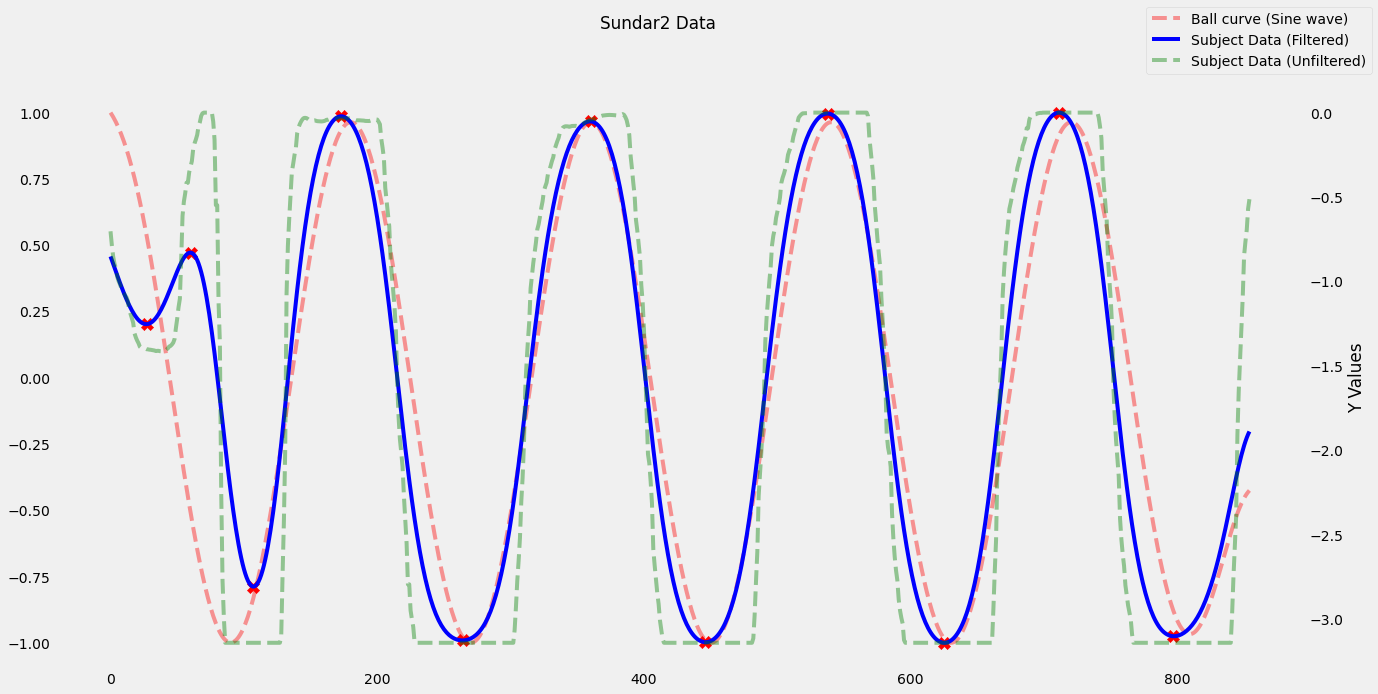

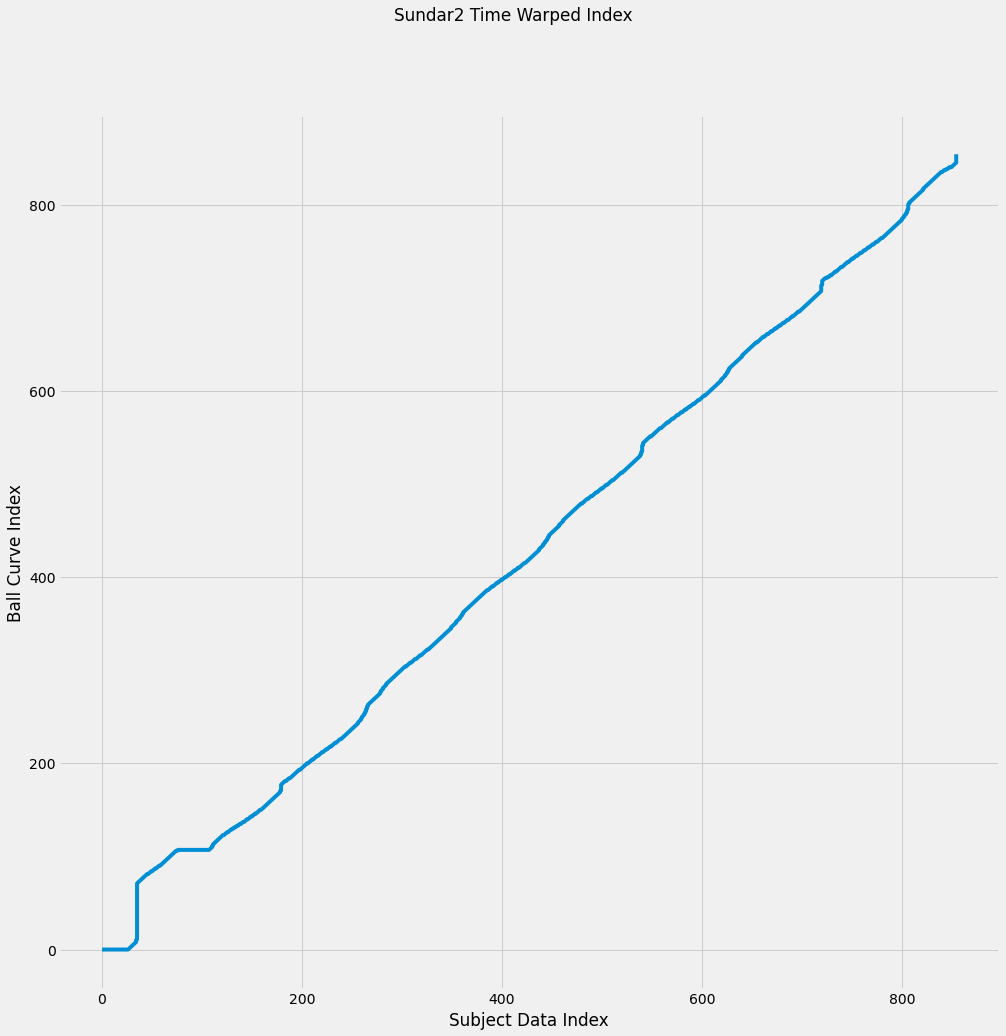

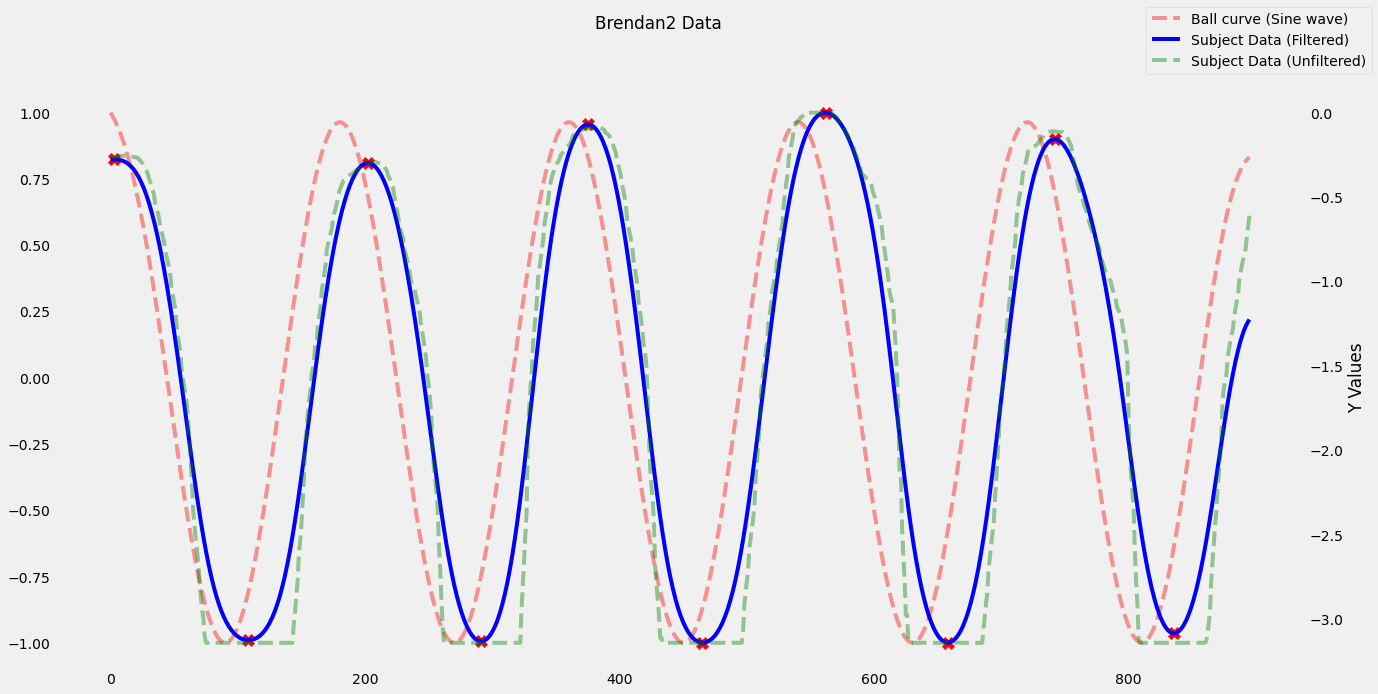

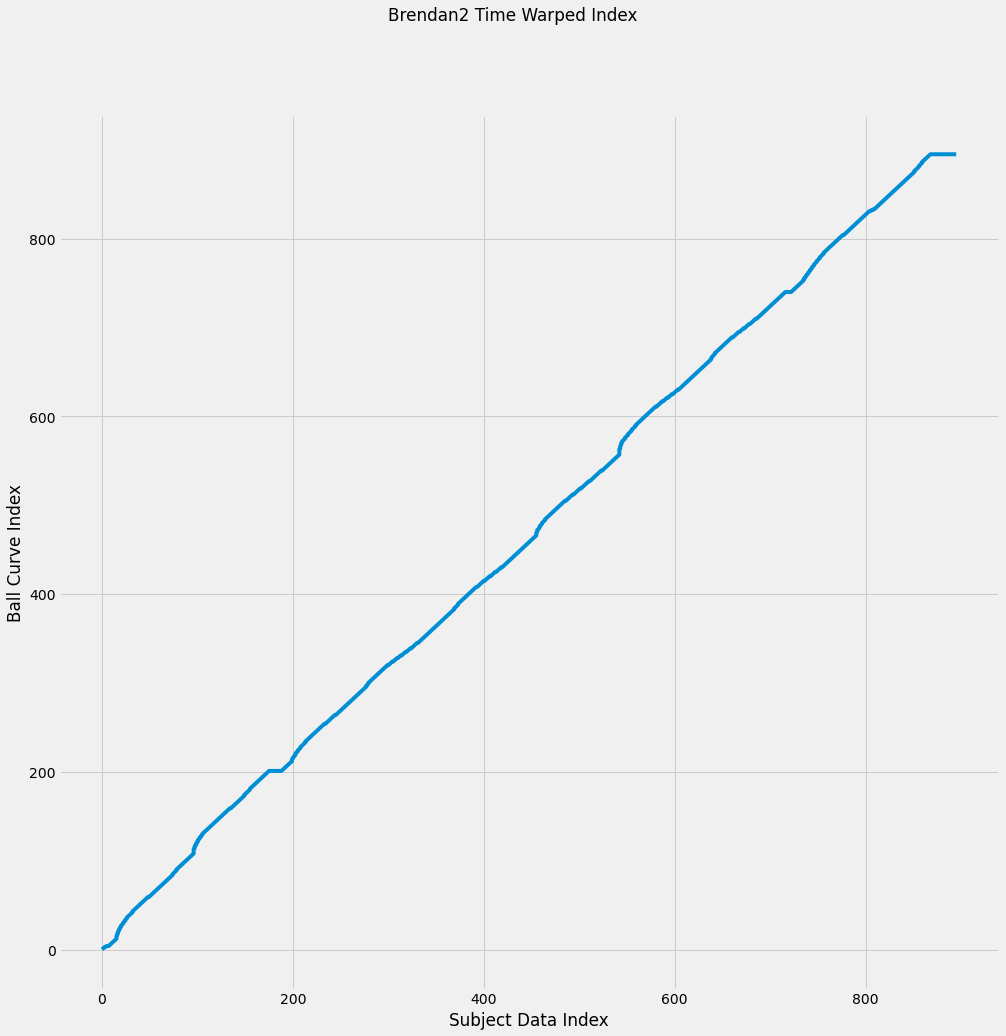

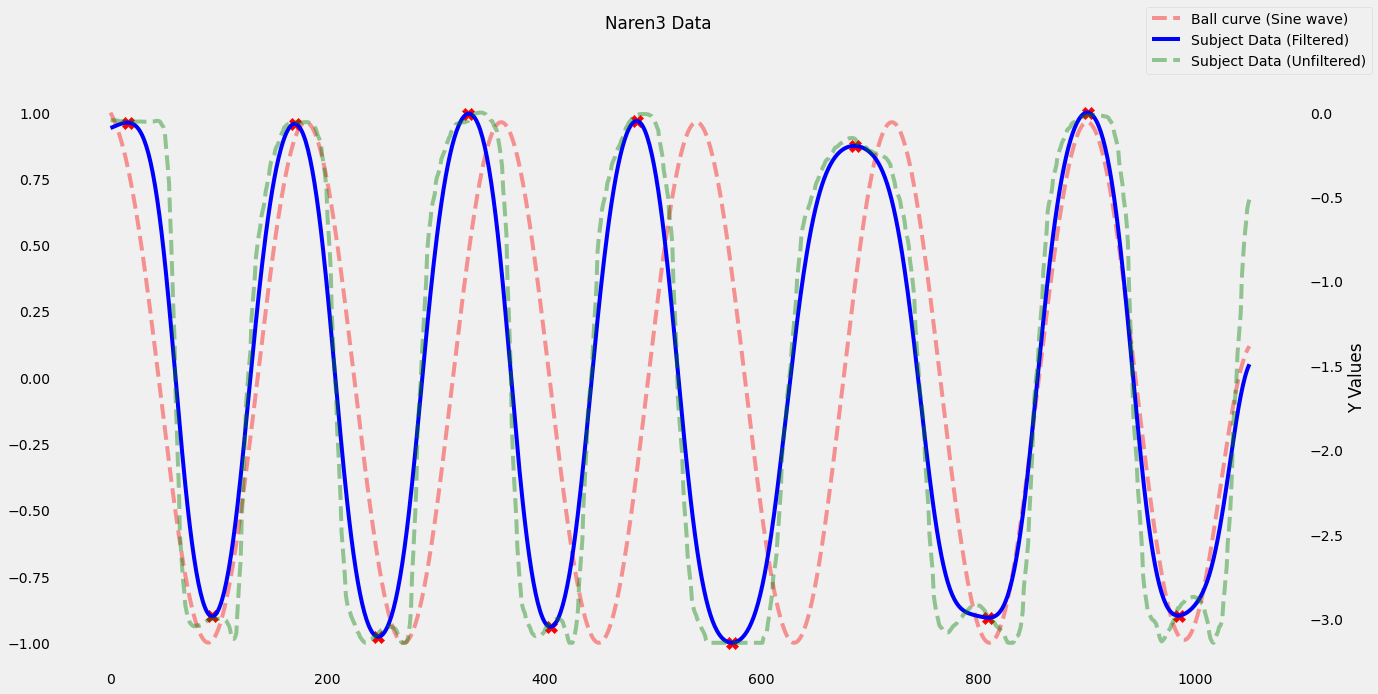

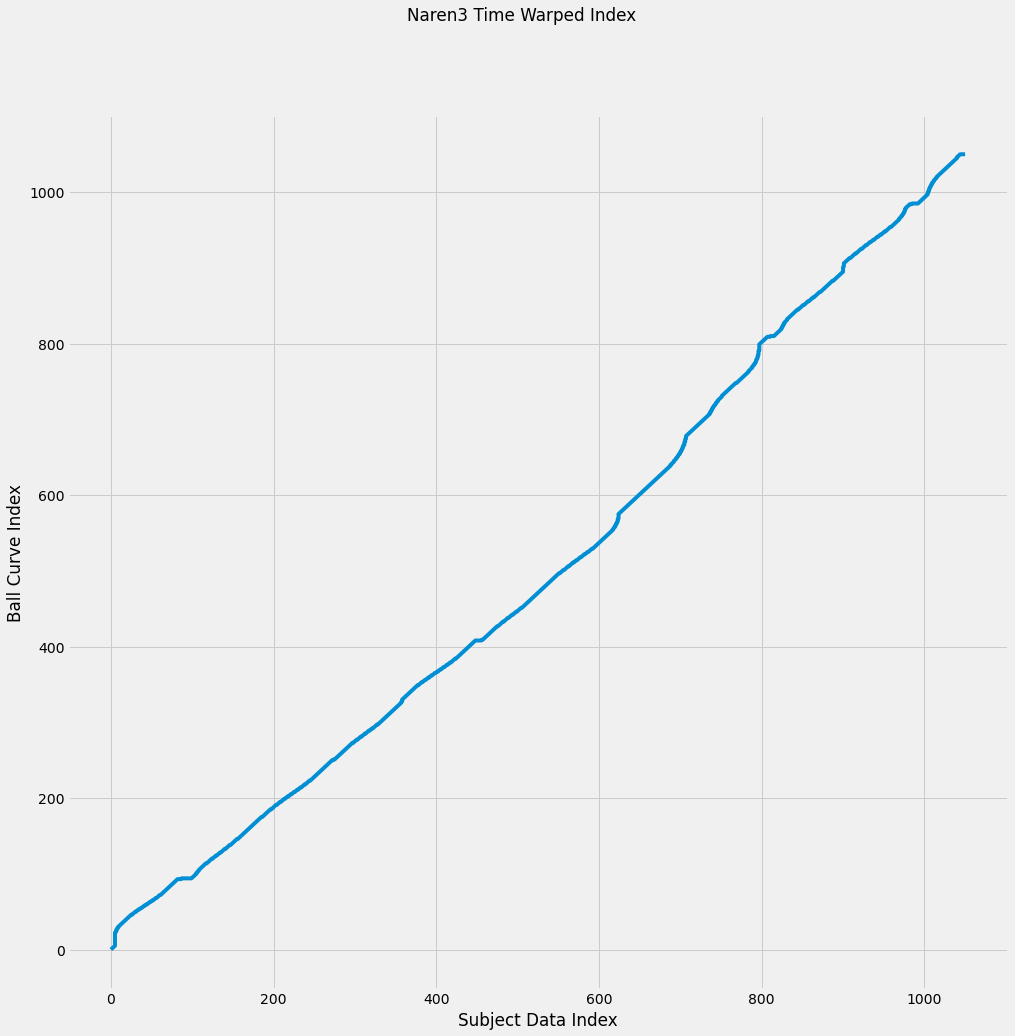

In [42]:
interested_subjects = ["Sundar2", "Brendan2", "Naren3"]

# Filtered Signal
sub_fs_cols = ["Subject", "FS DTW Distance", "FS Horizontal Distance"]
sub_fs_df = pd.DataFrame(columns=sub_fs_cols)

for sub in interested_subjects:
    temp = df[df["Subject"] == sub]
    dist, path, mdist, hdist = dtwAlgorithm(temp["RealVal"], temp["Data"], temp["Frame"], sub,
     filtering=True, plots=True)

    sub_fs_df = sub_fs_df.append(dict(zip(sub_fs_cols, [sub, mdist, hdist])), ignore_index=True)

# sub_fs_df

# Unfiltered Signal
sub_ufs_cols = ["Subject", "UFS DTW Distance", "UFS Horizontal Distance"]
sub_ufs_df = pd.DataFrame(columns=sub_ufs_cols)
for sub in interested_subjects:
    temp = df[df["Subject"] == sub]
    dist, path, mdist, hdist = dtwAlgorithm(temp["RealVal"], temp["Data"], temp["Frame"], sub,
     filtering=False, plots=False)

    sub_ufs_df = sub_ufs_df.append(dict(zip(sub_ufs_cols, [sub, mdist, hdist])), ignore_index=True)

# Unfiltered vs Filtered Signal
sub_uff_cols = ["Subject", "UFF DTW Distance", "UFF Horizontal Distance"]
sub_uff_df = pd.DataFrame(columns=sub_uff_cols)
for sub in interested_subjects:
    temp = df[df["Subject"] == sub]
    dist, path, mdist, hdist = dtwUnfiltered(temp["RealVal"], temp["RealVal"], temp["Frame"], sub,
     filtering=True, plots=False)

    sub_uff_df = sub_uff_df.append(dict(zip(sub_uff_cols, [sub, mdist, hdist])), ignore_index=True)


sub_fs_df = sub_fs_df.merge(sub_ufs_df, on="Subject")
sub_fs_df = sub_fs_df.merge(sub_uff_df, on="Subject")

sub_fs_df


In [51]:
def getMaxMinDF(data):
    data1 = data["RealVal"]
    data2 = data["Data"]
    xdata = data["Frame"]

    # Filtering
    data1_filtered = butter_lowpass_filter(data1, cutoff, fs, order)
    data2_filtered = butter_lowpass_filter(data2, cutoff, fs, order)

    data1_scaled = scaler(data1_filtered)
    data2_scaled = scaler(data2_filtered)

    # Get Maxima and Minima points
    maxima, minima = getMaxMinima(data2_scaled)
    maxima_data = data[data["Frame"].isin(maxima)]
    minima_data = data[data["Frame"].isin(minima)]

    return (maxima_data, minima_data)


In [53]:
for sub in interested_subjects:
    temp = df[df["Subject"] == sub]

    maxima_df, minima_df = getMaxMinDF(temp)
    print(sub+" Maxima Points")
    print(maxima_df)
    print(sub+" Minima Points")
    print(minima_df)


Sundar2 Maxima Points
      Subject  TimeStamp  Frame   RealVal      Data
3567  Sundar2   0.666408     60  1.501395 -0.320118
3680  Sundar2   1.921214    173  2.969329 -0.035242
3867  Sundar2   3.998018    360  2.999975 -0.041415
4045  Sundar2   5.975122    538  2.996885  0.000000
4218  Sundar2   7.896245    711  2.947090  0.000000
Sundar2 Minima Points
      Subject  TimeStamp  Frame   RealVal      Data
3534  Sundar2   0.299810     27  2.588913 -1.401993
3614  Sundar2   1.188192    107  1.169297 -3.141593
3771  Sundar2   2.931885    264  1.022978 -3.141593
3953  Sundar2   4.953221    446  1.010896 -3.141593
4132  Sundar2   6.941146    625  1.017191 -3.141593
4304  Sundar2   8.851401    797  1.107362 -3.141593
Brendan2 Maxima Points
       Subject  TimeStamp  Frame   RealVal      Data
879   Brendan2   0.033213      3  2.994644 -0.261873
1078  Brendan2   2.243298    202  2.722388 -0.300412
1251  Brendan2   4.164698    375  2.869494 -0.094955
1438  Brendan2   6.241494    562  2.726295  0